In [1]:
from data import get_loader, get_data_path
import torch.nn as nn
from torch.utils import data
import numpy as np

IMG_MEAN = np.array((104.00698793,116.66876762,122.67891434), dtype=np.float32)
input_size = (512,1024)

num_classes = 19
data_loader = get_loader('cityscapes')
data_path = get_data_path('cityscapes')
test_dataset = data_loader( data_path, img_size=input_size, img_mean = IMG_MEAN, is_transform=True, split='val')
testloader = data.DataLoader(test_dataset, batch_size=1, shuffle=False, pin_memory=True)
interp = nn.Upsample(size=input_size, mode='bilinear', align_corners=True)
ignore_label = 250

Found 478 val images


In [2]:
from torchvision import transforms
from trainUDA import DeNormalize

restore_transform = transforms.Compose([
DeNormalize(IMG_MEAN),
transforms.ToPILImage()])


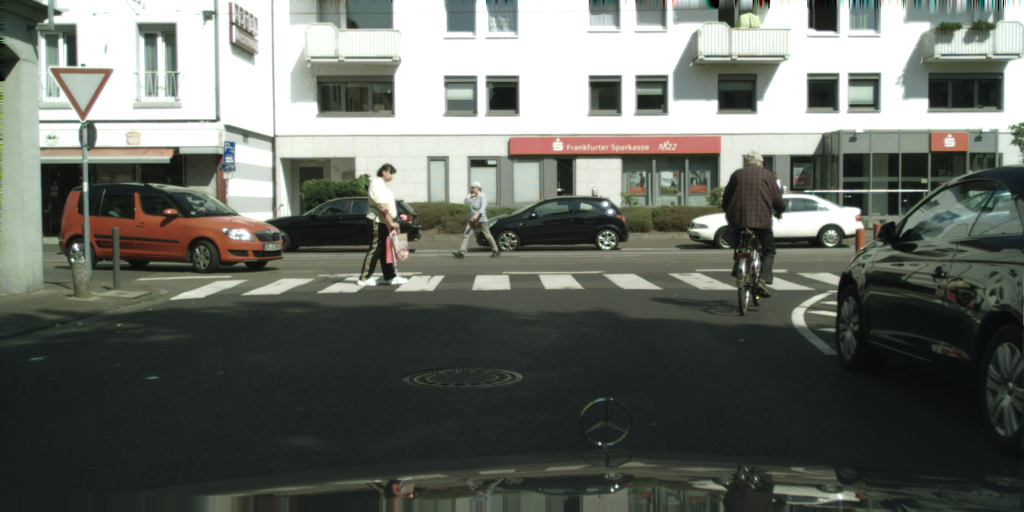

In [6]:
img, label, _, _, _ = test_dataset[0]
image = restore_transform(img)
image

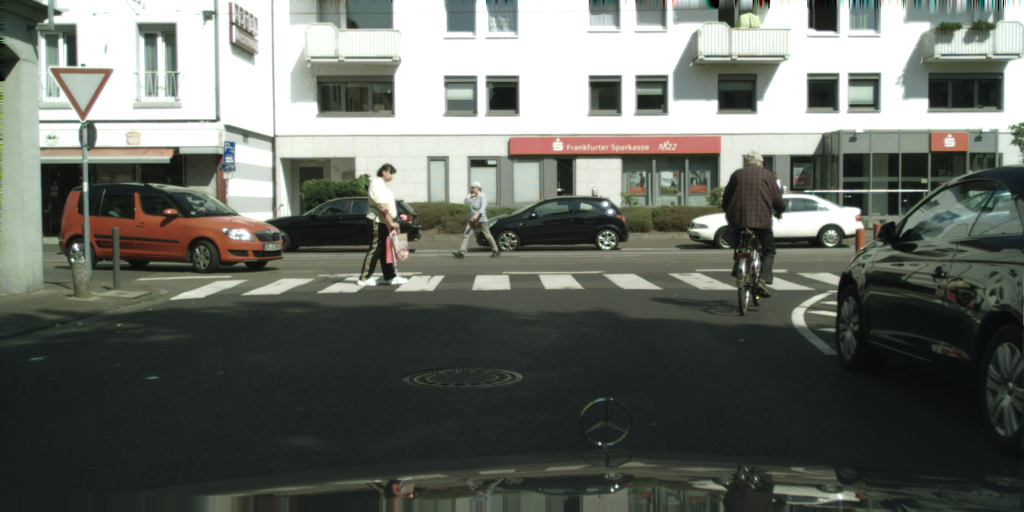

In [11]:
testloader_iter = iter(testloader)
img, label, _, _, _ = next(testloader_iter)
image = restore_transform(img[0])
image

# GTA

In [26]:
num_classes = 19
data_loader = get_loader('gta_test')
data_path = get_data_path('gta')
test_dataset = data_loader(data_path, list_path = './data/gta5_list/train.txt', img_size=(1280,720), mean=IMG_MEAN)
testloader = data.DataLoader(test_dataset, batch_size=1, shuffle=True, pin_memory=True)
interp = nn.Upsample(size=(720,1280), mode='bilinear', align_corners=True)
ignore_label = 255

In [39]:
from torchvision import transforms
import torch
class DeNormalize(object):
    def __init__(self, mean):
        self.mean = mean

    def __call__(self, tensor):
        IMG_MEAN = torch.from_numpy(self.mean.copy())
        IMG_MEAN, _ = torch.broadcast_tensors(IMG_MEAN.unsqueeze(1).unsqueeze(2), tensor)
        tensor = tensor+IMG_MEAN
        tensor = (tensor/255).float()
        tensor = torch.flip(tensor,(0,))
        return tensor

    
restore_transform = transforms.Compose([
DeNormalize(IMG_MEAN),
transforms.ToPILImage()])


In [42]:
img, label, _, _, _ = test_dataset[1]
# gta dataset returns numpy array, which is then converted to torch tensor in the dataloader
# however, since I'm using the dataset rather than the dataloader here, I need to convert to tensor manually.
image = restore_transform(torch.tensor(img))

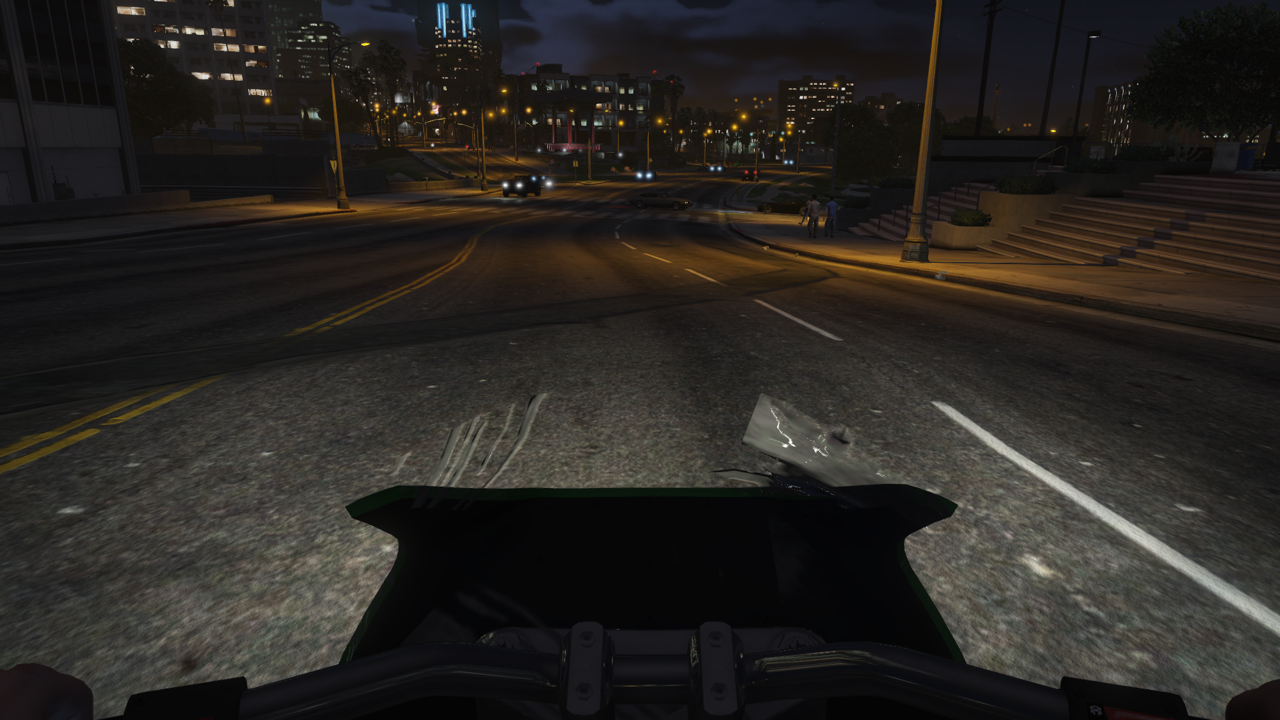

In [43]:
image

# Self-supervised Data Loaders

In [5]:
from data.gta5_dataset import SsGTA5
from data.cityscapes_loader import SsCityscapes
import numpy as np
from data import get_data_path
from torchvision import transforms
import torch
import matplotlib.pyplot as plt
%matplotlib inline
class DeNormalize(object):
    def __init__(self, mean):
        self.mean = mean

    def __call__(self, tensor):
        IMG_MEAN = torch.from_numpy(self.mean.copy())
        IMG_MEAN, _ = torch.broadcast_tensors(IMG_MEAN.unsqueeze(1).unsqueeze(2), tensor)
        tensor = tensor+IMG_MEAN
        tensor = (tensor/255).float()
        tensor = torch.flip(tensor,(0,))
        return tensor

IMG_MEAN = np.array((104.00698793, 116.66876762, 122.67891434), dtype=np.float32)

restore_transform = transforms.Compose([
DeNormalize(IMG_MEAN),
transforms.ToPILImage()])


In [2]:
IMG_MEAN = np.array((104.00698793, 116.66876762, 122.67891434), dtype=np.float32)
data_path = get_data_path('gta')

source_ds = SsGTA5(
    root=data_path,
    list_path='./data/gta5_list/train.txt',
    augmentations=None,
    img_size=(1280,720),
    mean=IMG_MEAN,
    crop_size=256
    )

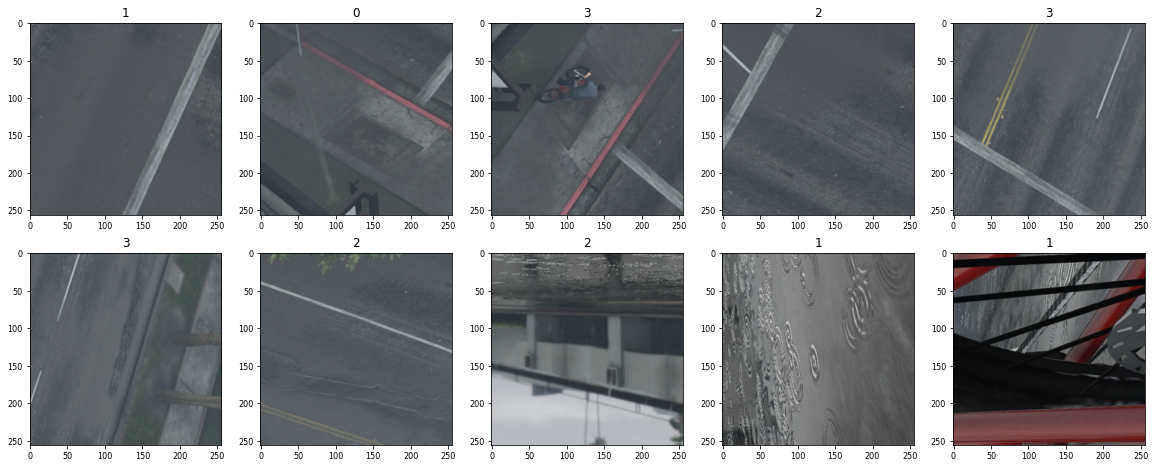

In [15]:
n_cols = 5

start = 12160
end = 12170
plt.figure(figsize=(20,8*((end - start) // n_cols + 1) / 2))
for i, indx in enumerate(range(start, end)):
    img, label = source_ds[indx]
    image = restore_transform(torch.tensor(img))
    plt.subplot((end - start) // n_cols + 1, n_cols, i + 1)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.imshow(image)
    plt.title(label)


In [9]:
IMG_MEAN = np.array((104.00698793, 116.66876762, 122.67891434), dtype=np.float32)
data_path = get_data_path('cityscapes')

target_ds = SsCityscapes(
    root=data_path,
    split="train",
    is_transform=True,
    augmentations=None,
    img_mean=IMG_MEAN,
    crop_size=256
    )

Found 2831 train images


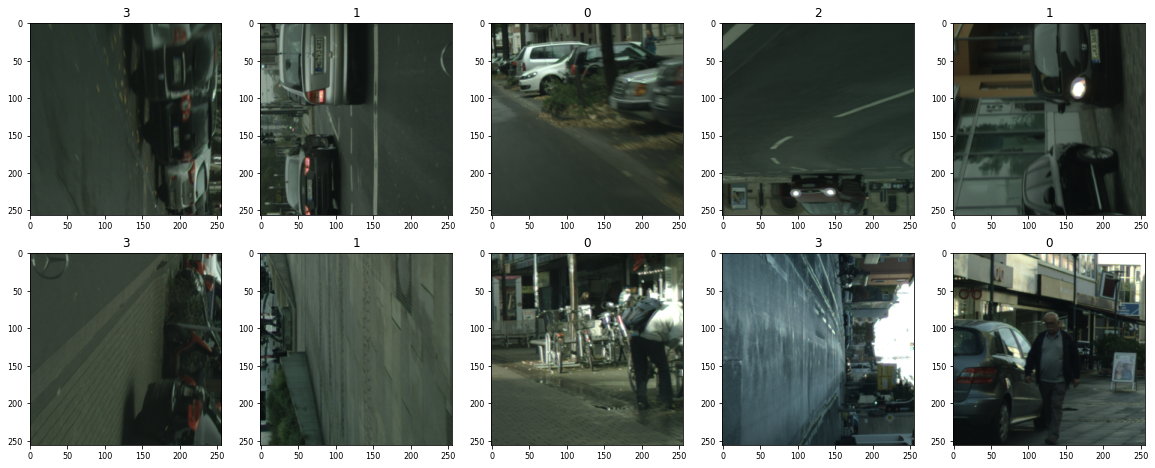

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
n_cols = 5

start = 210
end = 220
plt.figure(figsize=(20,8*((end - start) // n_cols + 1) / 2))
for i, indx in enumerate(range(start, end)):
    img, label = target_ds[indx]
    image = restore_transform(torch.tensor(img))
    plt.subplot((end - start) // n_cols + 1, n_cols, i + 1)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.imshow(image)
    plt.title(label)


In [61]:
2048*16*16*4

2097152

In [1]:
import torch

In [90]:
def custom_loss(pred, gt):
    p = torch.max(pred, torch.tensor([2.0]))
    loss = torch.nn.MSELoss()(torch.abs(p - gt), torch.zeros_like(pred))
    return loss

In [91]:
pred = torch.tensor([2.01], requires_grad=True)
gt = torch.tensor([0.], requires_grad=False)


loss = custom_loss(pred, gt)
print(loss)
loss.backward()

tensor(4.0401, grad_fn=<MseLossBackward0>)


In [ ]:
#getting

In [92]:
print(pred.grad)

tensor([4.0200])


In [93]:
import numpy as np
grads = []
for x in np.linspace(-5,5):
    pred = torch.tensor([x], requires_grad=True)
    loss = custom_loss(pred, torch.zeros_like(pred))
    loss.backward()
    grads.append(pred.grad.item())


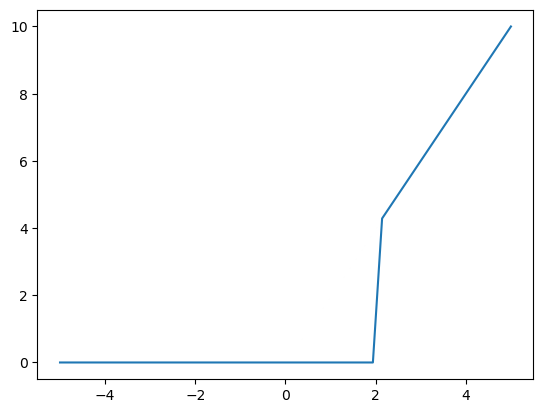

In [94]:
import matplotlib.pyplot as plt

plt.plot(np.linspace(-5,5), grads)